# Skapa 2 modeller per ticker   
1. En modell som använder tomorrows close som target  
2. En modell som använder day after tomorrows close som target   

In [3]:
import sklearn
import xgboost as xgb
from pytrends.request import TrendReq
import pytrends
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import ta
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
plt.style.use('fivethirtyeight')
pd.set_option('display.width', 200)
import streamlit as st
import google

In [4]:
# print pandas version
print('pandas=={}'.format(pd.__version__))
# print matplotlib version
print('matplotlib=={}'.format(plt.matplotlib.__version__))
# print yfinance version
print('yfinance=={}'.format(yf.__version__))
# print pytreands version
print('pytrends==4.8.0') 
# print python-dateutil version
print('python-dateutil==2.8.2')
# print ta version
print('ta==0.10.2')
# print streamlit version
print('streamlit=={}'.format(st.__version__))
print('xgboost=={}'.format(xgb.__version__))
print('sklearn=={}'.format(sklearn.__version__))
#print google version
print('google-crc32==1.1.2')
# print pandas-ta version
print('pandas-ta==0.3.14b0')


pandas==1.4.3
matplotlib==3.5.2
yfinance==0.1.72
pytrends==4.8.0
python-dateutil==2.8.2
ta==0.10.2
streamlit==1.13.0
xgboost==1.6.1
sklearn==1.1.1
google-crc32==1.1.2
pandas-ta==0.3.14b0


In [5]:
tickers = ['BTC-USD','ETH-USD','BCH-USD','ZRX-USD','XRP-USD']
ticker_names = ['Bitcoin','Ethereum','Bitcoin Cash','0X','Ripple']

In [6]:
# fill up a dataframe with all dates from 2015 up to today
def get_all_dates():
    start_date = dt(2005, 1, 1)
    end_date = dt.today()
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    return df


## get Google Trends Crypto data


Bitcoin
Ethereum
Bitcoin Cash
0X
Ripple


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_30,Ethereum_30,Bitcoin Cash_30,0X_30,Ripple_30,Bitcoin_90,Ethereum_90,Bitcoin Cash_90,0X_90,Ripple_90,Bitcoin_250,Ethereum_250,Bitcoin Cash_250,0X_250,Ripple_250
2022-10-04,0.733333,0.733333,0.1,0.0,0.1,0.877778,0.993333,0.128889,0.115556,0.1,0.996667,1.112222,0.141111,0.299630,0.1,1.179733,1.237200,0.174133,0.348133,0.124933
2022-10-05,0.733333,0.733333,0.1,0.0,0.1,0.872222,0.983333,0.127778,0.111111,0.1,0.991111,1.107037,0.140370,0.298148,0.1,1.176667,1.233333,0.173600,0.347200,0.124667
2022-10-06,0.733333,0.733333,0.1,0.0,0.1,0.866667,0.973333,0.126667,0.106667,0.1,0.985556,1.101852,0.139630,0.296667,0.1,1.173600,1.229467,0.173067,0.346267,0.124400
2022-10-07,0.733333,0.733333,0.1,0.0,0.1,0.861111,0.963333,0.125556,0.102222,0.1,0.980000,1.096667,0.138889,0.295185,0.1,1.170533,1.225600,0.172533,0.345333,0.124133
2022-10-08,0.733333,0.733333,0.1,0.0,0.1,0.855556,0.953333,0.124444,0.097778,0.1,0.974444,1.091481,0.138148,0.293704,0.1,1.167467,1.221733,0.172000,0.344400,0.123867


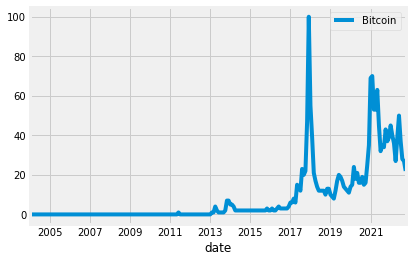

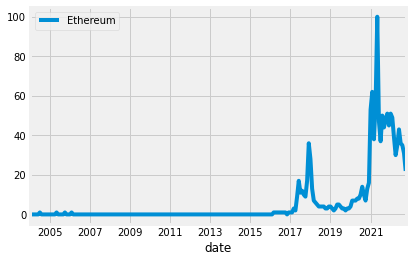

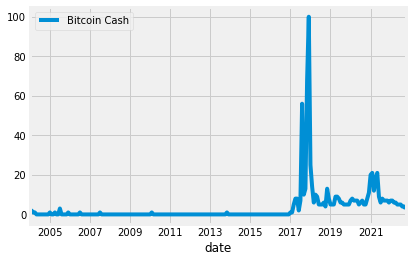

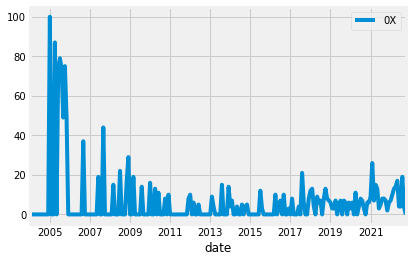

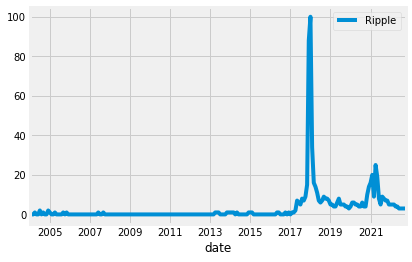

In [7]:
# get google trends data
from pytrends.request import TrendReq

pytrends = TrendReq()
df_trend = get_all_dates()
for ticker_name in ticker_names:
    print(ticker_name)
    pytrends.build_payload(kw_list=[ticker_name], cat=7, timeframe='all')
    df_temp = pytrends.interest_over_time()
    df_temp = df_temp.drop(columns=['isPartial'])
    df_temp.plot()
    df_trend = df_trend.merge(df_temp, how='left', left_index=True, right_index=True)
    df_trend[ticker_name] = df_trend[ticker_name].fillna(method='ffill')/30
    df_trend[ticker_name+'_30'] = df_trend[ticker_name].rolling(30, 1).mean()
    df_trend[ticker_name+'_90'] = df_trend[ticker_name].rolling(90, 1).mean()
    df_trend[ticker_name+'_250'] = df_trend[ticker_name].rolling(250, 1).mean()
    
    
# gruppera kolumnerna per typ av data
df_trend = df_trend[ticker_names + [ticker_name+'_30' for ticker_name in ticker_names] + [ticker_name+'_90' for ticker_name in ticker_names] + [ticker_name+'_250' for ticker_name in ticker_names]]

df_trend.tail()


In [8]:
df_trend.to_csv('google_trends.csv')


## skapa alla modellerna

In [9]:
df_trend.query('index>"2017-01-01"').sample(6)


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_30,Ethereum_30,Bitcoin Cash_30,0X_30,Ripple_30,Bitcoin_90,Ethereum_90,Bitcoin Cash_90,0X_90,Ripple_90,Bitcoin_250,Ethereum_250,Bitcoin Cash_250,0X_250,Ripple_250
2022-05-21,1.300000,1.166667,0.166667,0.566667,0.133333,1.180000,1.116667,0.176667,0.536667,0.133333,1.135185,1.198519,0.195185,0.466667,0.147778,1.265333,1.461067,0.215467,0.303467,0.182933
2020-12-29,1.166667,0.533333,0.366667,0.200000,0.466667,1.155556,0.530000,0.363333,0.200000,0.462222,0.837407,0.396667,0.264444,0.131111,0.307407,0.673733,0.353600,0.224400,0.147467,0.209333
2017-06-20,0.466667,0.566667,0.066667,0.133333,0.200000,0.477778,0.477778,0.133333,0.088889,0.211111,0.369259,0.261481,0.212222,0.029630,0.150370,0.239333,0.117333,0.098933,0.052933,0.067333
2019-02-18,0.300000,0.100000,0.166667,0.100000,0.166667,0.313333,0.113333,0.166667,0.140000,0.166667,0.372222,0.122963,0.230741,0.198889,0.200741,0.384400,0.122800,0.210933,0.221200,0.232267
2018-01-30,1.833333,0.933333,0.833333,0.400000,3.333333,1.833333,0.933333,0.833333,0.400000,3.333333,2.264074,0.907037,2.156296,0.225185,2.282593,1.204933,0.576267,1.153867,0.207867,0.972267
2021-05-03,2.100000,3.333333,0.700000,0.433333,0.633333,1.800000,2.013333,0.610000,0.493333,0.813333,1.941481,1.766667,0.563333,0.511852,0.594815,1.386267,1.068000,0.413867,0.293867,0.420000


In [10]:
def get_all(tickers):
    df = pd.DataFrame()
    for ticker in tickers:
        all_tickers = yf.download(ticker)
        df[ticker] = yf.download(ticker, period='max')['Close']
        
    df.index = pd.to_datetime(df.index)
    return df

In [11]:
df_org= get_all(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [12]:
display(df_org.isna().sum())
df_org.shape

BTC-USD       0
ETH-USD    1149
BCH-USD    1149
ZRX-USD    1081
XRP-USD    1149
dtype: int64

(2944, 5)

In [13]:

def fit_predict(train, test, target, predictors, model, proba_val=None):
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined



Backtest av modellerna

In [14]:
def backtest(data, target, model, predictors, gap=0, proba_val=0.6, start=360, step=180):
    """"
    Args:
        data (DataFrame): Data to use for backtesting
        taregt (str): Name of the target column
        model: Tex RandomForestClassifier
        predictors: Features in data to use for backtesting
        proba_val (float): threshold för att få 1 annars 0 i predictions.
        start (int, optional): Hur många rader in i data skall vi starta testet. Defaults to 180.
        step (int, optional): Hur många rader skall vi ta i varje batch framåt. Defaults to 60.

    Returns:
        DataFrame: Två kolumner med true_y och prediktioner 
    """
    all_predictions = []
    print('last date', (data.iloc[-1].name).date())
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[(i+gap):(i+step)].copy()
        predictions = fit_predict(train, test, target, predictors, model, proba_val=proba_val)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


def print_results(predictions, target):
    prec = precision_score(predictions[target], predictions["Predictions"])
    print(f'Fördelning av {target}: 1 vs 0:')
    print(predictions[target].value_counts() / predictions.shape[0])

    predictions.Predictions = predictions.Predictions.astype(int)
    print(predictions.value_counts())
    print(f"Precision:\t{prec:.4f}")
    return prec


### Beräkna predictors

In [15]:
def new_features(df_, ticker, target, horizons=[2,5,60,250]):
    df = df_.copy()
    # tidsintervall i dagar för rullande medelvärden
    # skulle helst ha med upp till 4 år men ETH har för få värden
    
    new_predictors = []
    df['stoch_k'] = ta.momentum.stochrsi_k(df[ticker], window=10)

    # Target
    # tomorrow's close price - alltså nästa dag
    df['Tomorrow'] = df[ticker].shift(-1)
    # after tomorrow's close price - alltså om två dagar
    df['After_tomorrow'] = df[ticker].shift(-2)
    df['y1'] = (df['Tomorrow'] > df[ticker]).astype(int)
    df['y2'] = (df['After_tomorrow'] > df[ticker]).astype(int)
    # df.dropna(inplace=True)

    for horizon in horizons:
        rolling_averages = df.rolling(horizon, min_periods=1).mean()

        ratio_column = f"Close_Ratio_{horizon}"
        df[ratio_column] = df[ticker] / rolling_averages[ticker]

        # edit_column = f"edit_{horizon}"
        # df[edit_column] = rolling_averages['edit_count']
        ## Den ovan ändras till min Google Trends och görs på annan plats
        
        rolling = df.rolling(horizon,closed='left', min_periods=1).mean()
        
        trend_column = f"Trend_{horizon}"
        target_name = 'Tomorrow' if target=='y1' else 'After_tomorrow'
        df[trend_column] = rolling[target_name]     #### OBS! Skilj trend_column från Google Trends

        new_predictors += [ratio_column, trend_column]

    df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month

    new_predictors += ['stoch_k','day_of_month','day_of_week','month']
    # df = df.dropna()
    return df, new_predictors


In [16]:
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
pd.options.display.precision = 4      # default 6
# print(tickers[0])
# df, new_predictors = new_features(df_org, tickers[0], 'y1')
# df[new_predictors+['y1']]


### Vi använder XGBoost

Loop öve all tickers och skapa 2 modeller  
    En mot y1 och en mot y2  
    spara båda modellerna  
Totalt 2 modeller per ticker    

Modellens namn:  
    ticker[:3]_y1  
    ticker[:3]_y2

In [17]:
def add_google_trends(df_, df_trend, ticker, new_predictors):
    df = df_.copy()
    
    lookup = {'BTC-USD': 'Bitcoin', 'ETH-USD': 'Ethereum', 'BCH-USD': 'Bitcoin Cash', 'XRP-USD': 'Ripple', 'ZRX-USD': '0X'}
    ticker_namn = lookup[ticker]
    
    df[ticker_namn + '_goog30'] = df_trend[ticker_namn + '_30']
    new_predictors.append(ticker_namn + '_goog30')
    df[ticker_namn + '_goog90'] = df_trend[ticker_namn + '_90']
    new_predictors.append(ticker_namn + '_goog90')
    df[ticker_namn + '_goog250'] = df_trend[ticker_namn + '_250']
    new_predictors.append(ticker_namn + '_goog250')
    
    return df, new_predictors


##### Generate all models and save them #####
def generate_all_models(df_org, tickers, horizons=[2,5,30,60,250], remove=[]):
    xgb_params = {'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7,
                'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4}
    precision_list=[]
    
    for ticker in tickers:
        namn = ticker[:3]
        print(namn)
        target = 'y1'
        model = xgb.XGBClassifier(**xgb_params,  random_state=2022, n_jobs=-1)
        df, new_predictors = new_features(df_org, ticker, target, horizons=horizons)
        df, new_predictors = add_google_trends(df, df_trend, ticker, new_predictors)
        
        if remove != []:
            for col in remove:
                new_predictors.remove(col)
        predictions_xgb = backtest(df, target, model, new_predictors, proba_val= 0.55, step=30)

        precision_list.append((namn+'1', print_results(predictions_xgb, target)))

        # display(pd.DataFrame(model.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False))
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = new_predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind='bar', title=namn+'1' , figsize=(10, 10)).get_figure())
        plt.show( )
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = xgb.XGBClassifier(early_stopping_rounds=100, 
                                **xgb_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[new_predictors], train[target],
                eval_set=[(train[new_predictors], train[target]),
                        (test[new_predictors], test[target])],
                verbose=False)

        model.save_model(f'{namn}_{target}.json')


        target='y2'
        model = xgb.XGBClassifier(**xgb_params,  random_state=2022, n_jobs=-1)
        df, new_predictors = new_features(df_org, ticker, target, horizons=horizons)
        df, new_predictors = add_google_trends(df, df_trend, ticker, new_predictors)

        if remove != []:
            for col in remove:
                new_predictors.remove(col)
        predictions_xgb = backtest(df, target, model, new_predictors, proba_val=0.55, step=30)

        precision_list.append((namn+'2',print_results(predictions_xgb, target)))
        
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = new_predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind = 'bar', title=namn+'2', figsize = (10, 10)).get_figure())
        plt.show()
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = xgb.XGBClassifier(early_stopping_rounds=100, 
                                **xgb_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[new_predictors], train[target],
                eval_set=[(train[new_predictors], train[target]),
                        (test[new_predictors], test[target])],
                verbose=False)

        model.save_model(f'{namn}_{target}.json')
        
    return precision_list,new_predictors


BTC
last date 2022-10-08
Fördelning av y1: 1 vs 0:
1    0.5414
0    0.4586
Name: y1, dtype: float64
y1  Predictions
1   0              1008
0   0               875
1   1               391
0   1               310
dtype: int64
Precision:	0.5578
Figure(720x720)


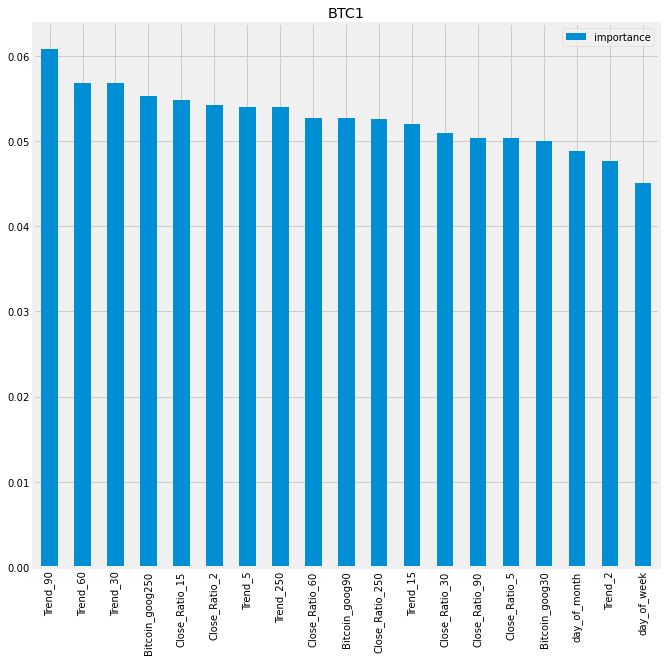

last date 2022-10-08
Fördelning av y2: 1 vs 0:
1    0.5538
0    0.4462
Name: y2, dtype: float64
y2  Predictions
1   0              970
0   0              766
1   1              461
0   1              387
dtype: int64
Precision:	0.5436
Figure(720x720)


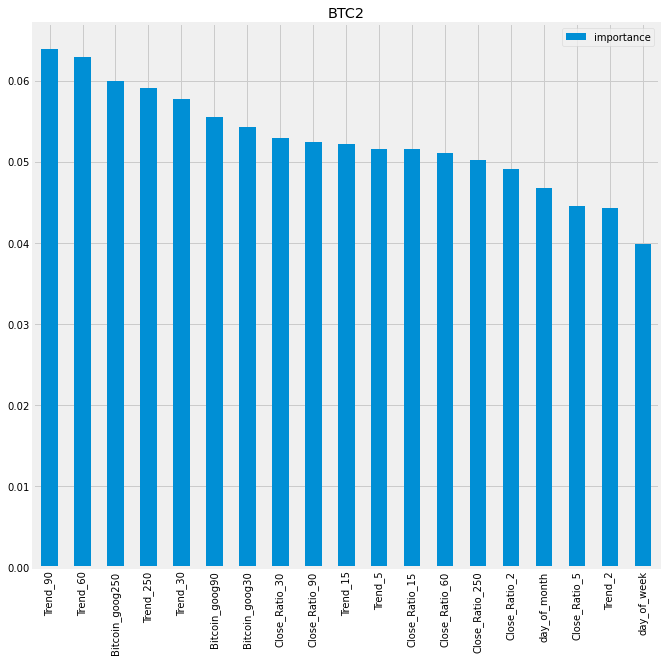

ETH
last date 2022-10-08
Fördelning av y1: 1 vs 0:
0    0.6436
1    0.3564
Name: y1, dtype: float64
y1  Predictions
0   0              1483
1   0               707
    1               214
0   1               180
dtype: int64
Precision:	0.5431
Figure(720x720)


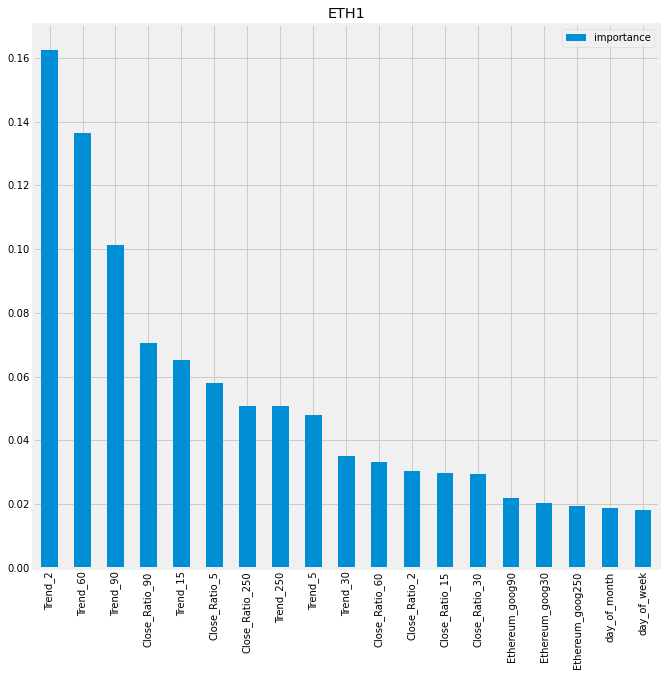

last date 2022-10-08
Fördelning av y2: 1 vs 0:
0    0.6428
1    0.3572
Name: y2, dtype: float64
y2  Predictions
0   0              1460
1   0               717
    1               206
0   1               201
dtype: int64
Precision:	0.5061
Figure(720x720)


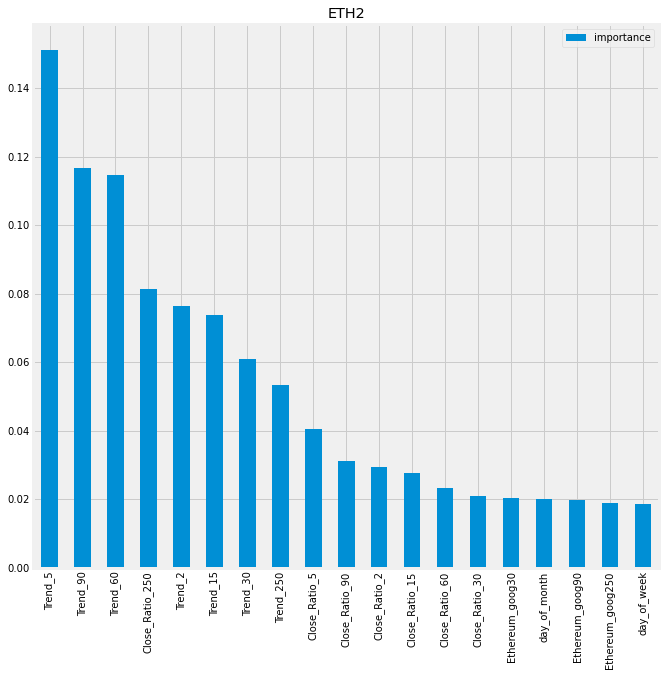

BCH
last date 2022-10-08
Fördelning av y1: 1 vs 0:
0    0.6637
1    0.3363
Name: y1, dtype: float64
y1  Predictions
0   0              1589
1   0               731
    1               138
0   1               126
dtype: int64
Precision:	0.5227
Figure(720x720)


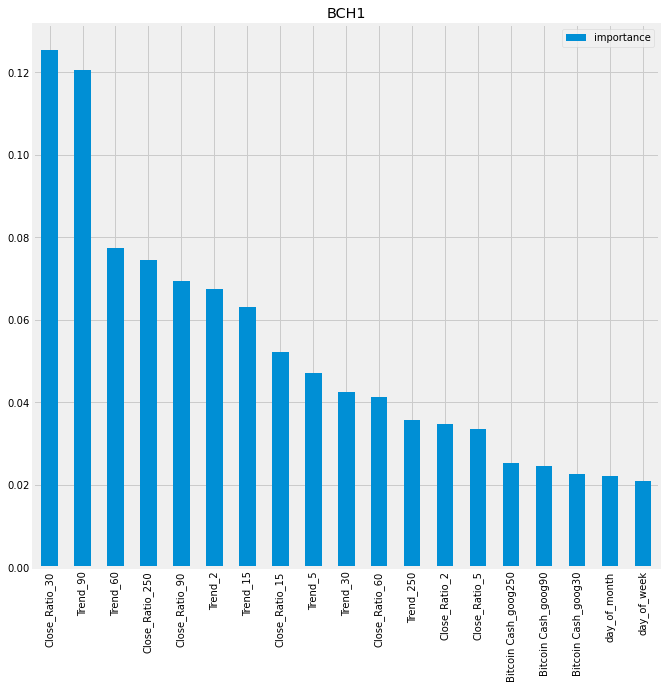

last date 2022-10-08
Fördelning av y2: 1 vs 0:
0    0.6699
1    0.3301
Name: y2, dtype: float64
y2  Predictions
0   0              1555
1   0               668
    1               185
0   1               176
dtype: int64
Precision:	0.5125
Figure(720x720)


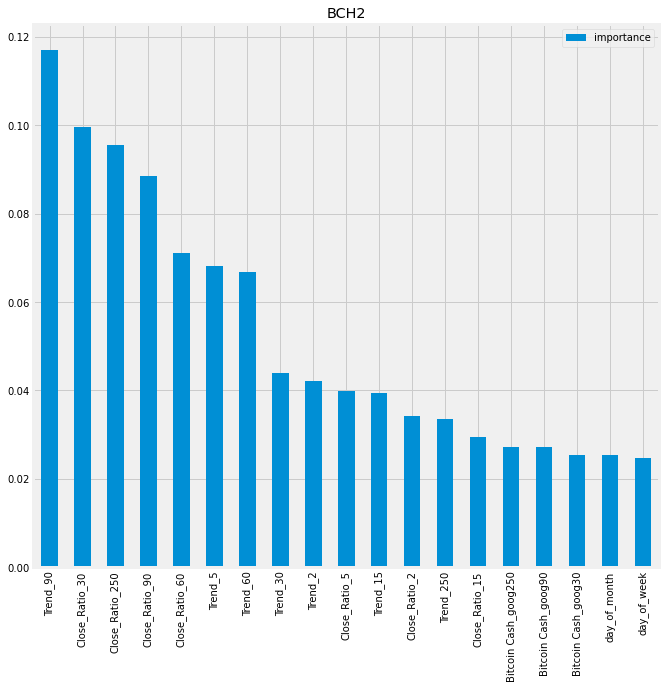

ZRX
last date 2022-10-08
Fördelning av y1: 1 vs 0:
0    0.6474
1    0.3526
Name: y1, dtype: float64
y1  Predictions
0   0              1531
1   0               732
    1               179
0   1               142
dtype: int64
Precision:	0.5576
Figure(720x720)


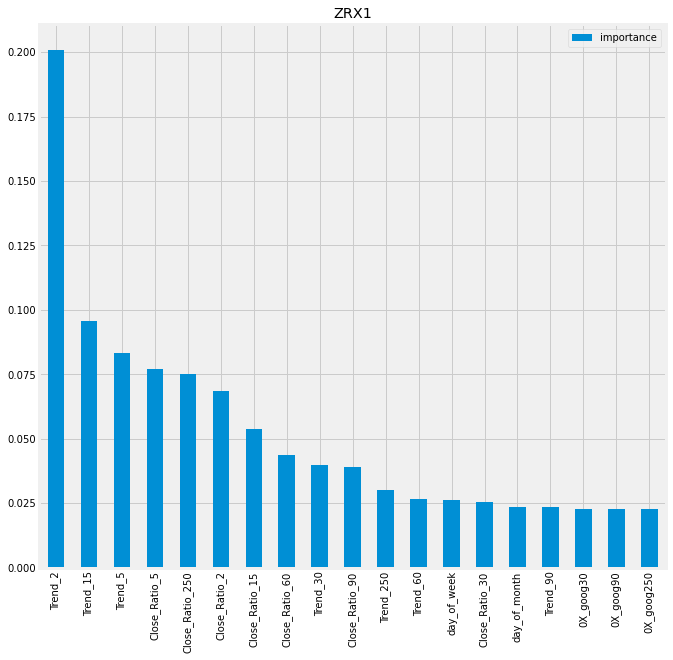

last date 2022-10-08
Fördelning av y2: 1 vs 0:
0    0.6544
1    0.3456
Name: y2, dtype: float64
y2  Predictions
0   0              1493
1   0               684
    1               209
0   1               198
dtype: int64
Precision:	0.5135
Figure(720x720)


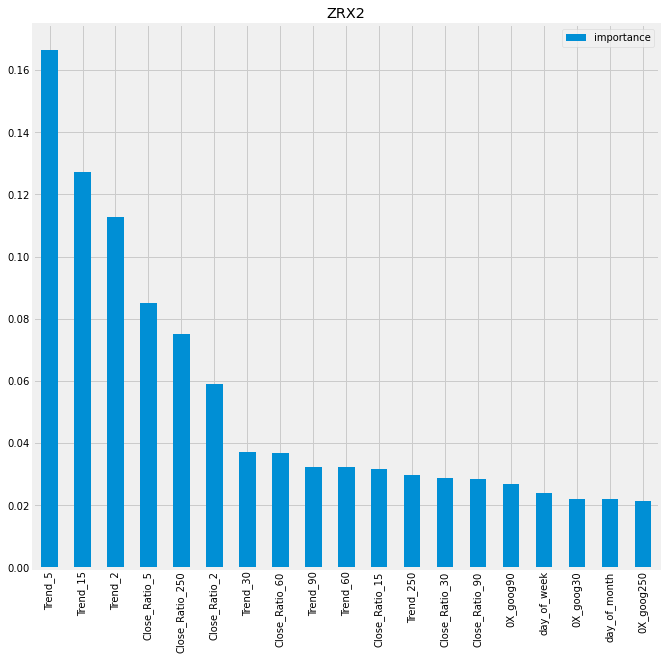

XRP
last date 2022-10-08
Fördelning av y1: 1 vs 0:
0    0.6583
1    0.3417
Name: y1, dtype: float64
y1  Predictions
0   0              1537
1   0               670
    1               213
0   1               164
dtype: int64
Precision:	0.5650
Figure(720x720)


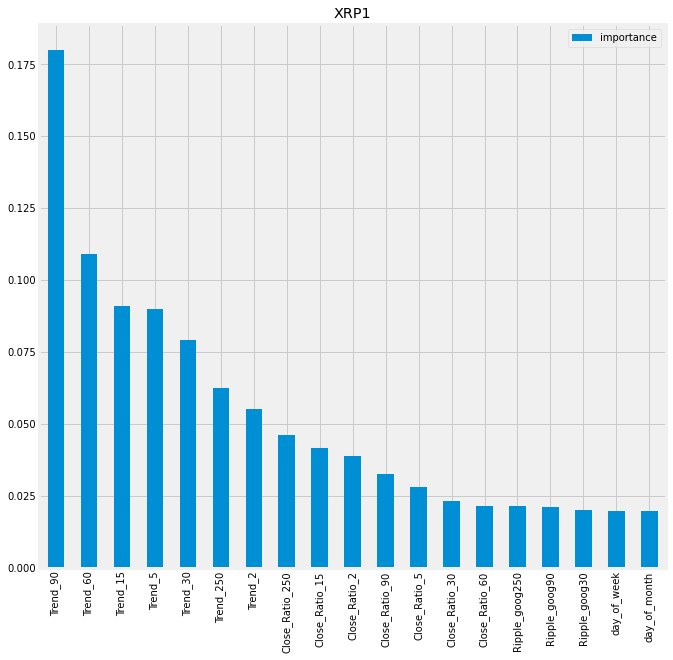

last date 2022-10-08
Fördelning av y2: 1 vs 0:
0    0.6707
1    0.3293
Name: y2, dtype: float64
y2  Predictions
0   0              1545
1   0               673
0   1               188
1   1               178
dtype: int64
Precision:	0.4863
Figure(720x720)


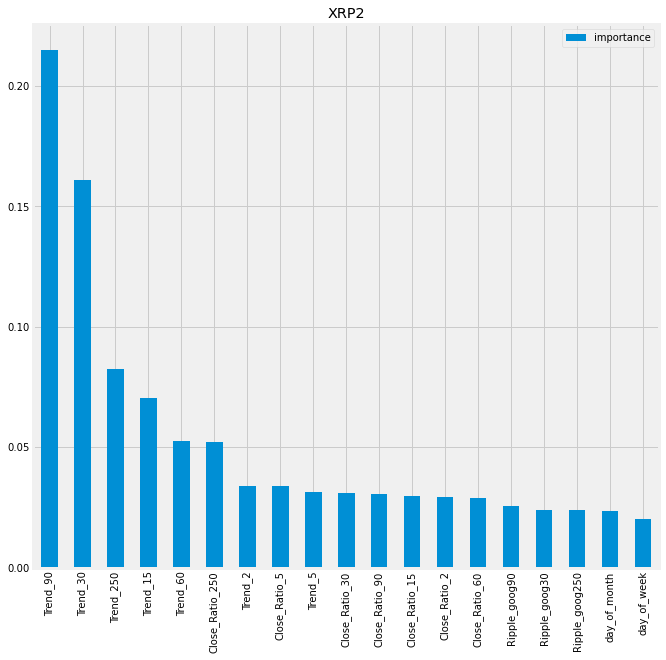

In [53]:
precision_list, new_predictors = generate_all_models(df_org, tickers, horizons=[2,5,15,30,60,90,250], remove=['month','stoch_k'])

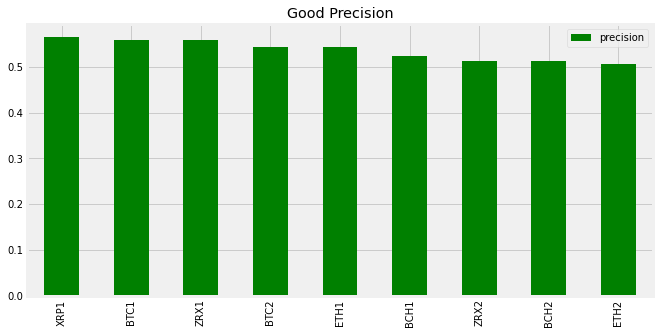

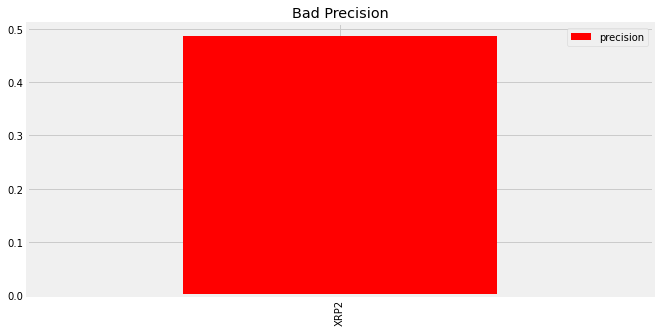

In [55]:
df_precision = pd.DataFrame(dict(precision_list), index=['precision']).T
# red color for negative values
df_precision.query('precision > 0.5').sort_values(by='precision',ascending=False).plot(kind='bar', figsize=(10,5), title = 'Good Precision', color='green')
try:
    df_precision.query('precision <= 0.5').sort_values(by='precision',ascending=False).plot(kind='bar', figsize=(10,5), title='Bad Precision',color='red')
except:
    pass


df_precision.to_csv('precision_no_month_stochk_15_90.csv')

Kollar TimeSeriesSplit Cross Validation  
Jag gillar min egen backtest-variant bätte   
- Den har start vilket garanterar att första Train-datat inte är för litet  
- Den har step-size i stället för n_splits vilka ger samma index-värden om så önskas  
- Båda har gap 

In [20]:
horizons=[2,5,15,30,60,90,250]
df, new_predictors = new_features(df_org, tickers[0], 'y1', horizons=horizons)
df, new_predictors = add_google_trends(df, df_trend, tickers[0], new_predictors)

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10,gap=1)
for train_index, test_index in tscv.split(df):
    print("TRAIN:", train_index[0], '-', train_index[-1], "\nTEST:", test_index[0], '-', test_index[-1])
    # X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    # y_train, y_test = df.iloc[train_index], df.iloc[test_index]


TRAIN: 0 - 272 
TEST: 274 - 540
TRAIN: 0 - 539 
TEST: 541 - 807
TRAIN: 0 - 806 
TEST: 808 - 1074
TRAIN: 0 - 1073 
TEST: 1075 - 1341
TRAIN: 0 - 1340 
TEST: 1342 - 1608
TRAIN: 0 - 1607 
TEST: 1609 - 1875
TRAIN: 0 - 1874 
TEST: 1876 - 2142
TRAIN: 0 - 2141 
TEST: 2143 - 2409
TRAIN: 0 - 2408 
TEST: 2410 - 2676
TRAIN: 0 - 2675 
TEST: 2677 - 2943


### Test plotly

In [54]:
df.columns

Index(['BTC-USD', 'ETH-USD', 'BCH-USD', 'ZRX-USD', 'XRP-USD', 'stoch_k', 'Tomorrow', 'After_tomorrow', 'y1', 'y2', 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_15',
       'Trend_15', 'Close_Ratio_30', 'Trend_30', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_90', 'Trend_90', 'Close_Ratio_250', 'Trend_250', 'day_of_month', 'day_of_week', 'month', 'Bitcoin_goog30',
       'Bitcoin_goog90', 'Bitcoin_goog250'],
      dtype='object')

In [47]:
df[['BTC-USD', 'ETH-USD', 'BCH-USD', 'ZRX-USD', 'XRP-USD','Tomorrow','After_tomorrow', 'Trend_2', 'Trend_5', 'Close_Ratio_2']]

,BTC-USD,ETH-USD,BCH-USD,ZRX-USD,XRP-USD,Tomorrow,After_tomorrow,Trend_2,Trend_5,Close_Ratio_2
Date,,,,,,,,,,
2014-09-17,457.3340,NaN,NaN,NaN,NaN,424.4400,394.7960,NaN,NaN,1.0000
2014-09-18,424.4400,NaN,NaN,NaN,NaN,394.7960,408.9040,424.4400,424.4400,0.9627
2014-09-19,394.7960,NaN,NaN,NaN,NaN,408.9040,398.8210,409.6180,409.6180,0.9638
2014-09-20,408.9040,NaN,NaN,NaN,NaN,398.8210,402.1520,401.8500,409.3800,1.0176
2014-09-21,398.8210,NaN,NaN,NaN,NaN,402.1520,435.7910,403.8625,406.7402,0.9875
...,...,...,...,...,...,...,...,...,...,...
2022-10-04,20336.8438,1362.1266,121.2456,0.2714,0.4802,20160.7168,19955.4434,19980.2119,19549.6832,1.0178
2022-10-05,20160.7168,1352.8372,122.2188,0.2689,0.4897,19955.4434,19546.8496,20248.7803,19695.4688,0.9957
2022-10-06,19955.4434,1351.7095,118.4388,0.2657,0.4932,19546.8496,19499.3242,20058.0801,19824.1383,0.9949


19979.41870244293

In [72]:
import plotly.express as px

# make aa plotly line chart with two lines
df_plot = df.query('index > "2022-01-01"').copy()
fig = px.line(df_plot, x=df_plot.index, y=['BTC-USD','ETH-USD','BCH-USD','ZRX-USD','XRP-USD'], title='Price')
# make fig higher and more narrow
fig.update_layout(height=600, width=1000)

fig.show()